In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from scipy.interpolate import interp1d
from astroNN.nn.layers import MCDropout

2022-05-17 02:24:11.543445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 02:24:11.543465: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-05-17 02:24:13.220401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-17 02:24:13.220425: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 02:24:13.220446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (isidro-pc): /proc/driver/nvidia/version does not exist


In [4]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 920901575586340133
]


2022-05-17 02:24:13.254877: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import pandas as pd
df=pd.read_csv('../../data/jla.csv')

In [6]:
dmag =df["dmb"]

In [7]:
#df = df[["zcmb", "mb","errors"]]

In [8]:
N = len(df.values)

Text(0, 0.5, '$\\mu(z)$')

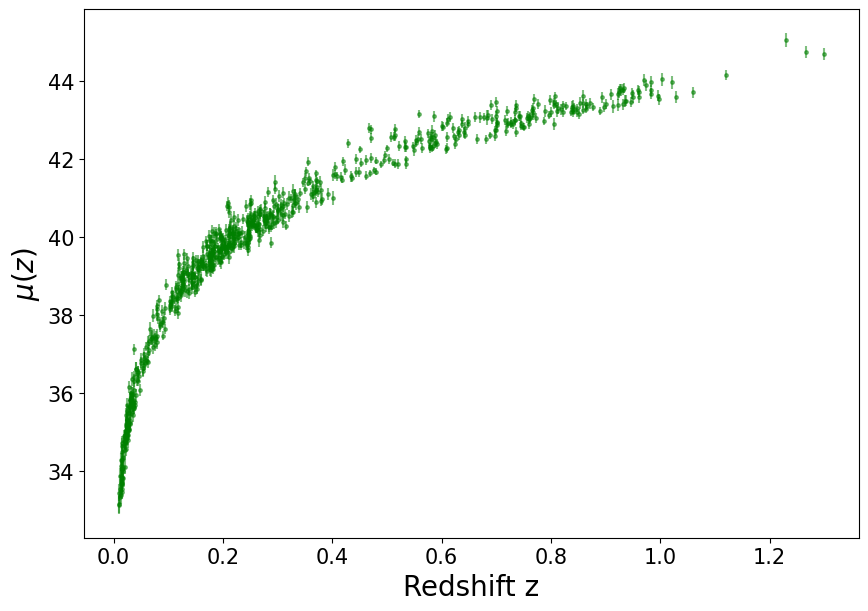

In [9]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)

In [10]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [11]:
z = data[:,0]
y = data[:,1:] ### coge el resto de variables a predecir 
# print(randomize)

In [12]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [13]:
### Modificar para incluir phanteon como test
split = 0.75
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]

In [15]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

In [16]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.75
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((555, 1), (555, 1), (185, 1), (185, 1))

In [17]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[3], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                 activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=3, activation="linear"))
    return model

#Define some parameter
batch_size = 16
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100, 150, 200,150])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))

/home/isidro/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-05-17 02:24:13.821848: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 146.4318 - val_loss: 147.1837
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 142.3611 - val_loss: 141.0022
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 133.4469 - val_loss: 126.3393
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 112.0771 - val_loss: 91.7913
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 70.3238 - val_loss: 42.2133
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 33.1433 - val_loss: 24.7549
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 26.8116 - val_loss: 21.4417
Epoch 8/1000
35/35 [==============================] - 0s 1ms/step - loss: 23.9460 - val_loss: 20.0960
Epoch 9/1000
35/35 [==============================] - 0s 1ms/step - loss: 23.6447 - val_loss: 19.1793
Epoch 10/1000
35/35 [==============================] - 0s 1ms/step - loss: 

Epoch 82/1000
35/35 [==============================] - 0s 1ms/step - loss: 2.6465 - val_loss: 2.7132
Epoch 83/1000
35/35 [==============================] - 0s 1ms/step - loss: 2.7632 - val_loss: 3.0763
Epoch 84/1000
35/35 [==============================] - 0s 1ms/step - loss: 2.6033 - val_loss: 2.9449
Epoch 85/1000
35/35 [==============================] - 0s 1ms/step - loss: 2.7192 - val_loss: 2.7009
Epoch 86/1000
35/35 [==============================] - 0s 2ms/step - loss: 2.4798 - val_loss: 2.2967
Epoch 87/1000
35/35 [==============================] - 0s 2ms/step - loss: 2.9476 - val_loss: 2.5551
Epoch 88/1000
35/35 [==============================] - 0s 2ms/step - loss: 2.7609 - val_loss: 2.6911
Epoch 89/1000
35/35 [==============================] - 0s 2ms/step - loss: 2.6157 - val_loss: 2.9967
Epoch 90/1000
35/35 [==============================] - 0s 2ms/step - loss: 2.5540 - val_loss: 2.8756
Epoch 91/1000
35/35 [==============================] - 0s 2ms/step - loss: 2.2441 - val_los

35/35 [==============================] - 0s 1ms/step - loss: 1.8382 - val_loss: 1.8367
Epoch 163/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.8447 - val_loss: 1.8222
Epoch 164/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.8119 - val_loss: 1.6712
Epoch 165/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.7691 - val_loss: 2.1131
Epoch 166/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.6609 - val_loss: 1.7103
Epoch 167/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.7053 - val_loss: 1.8317
Epoch 168/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.9836 - val_loss: 2.0543
Epoch 169/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.8911 - val_loss: 1.7617
Epoch 170/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.6052 - val_loss: 1.6025
Epoch 171/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.6762 - val_loss: 1.

35/35 [==============================] - 0s 1ms/step - loss: 1.5389 - val_loss: 1.3219
Epoch 243/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.4170 - val_loss: 1.5205
Epoch 244/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.3101 - val_loss: 1.5631
Epoch 245/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.4387 - val_loss: 1.3774
Epoch 246/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.4402 - val_loss: 1.7056
Epoch 247/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.5001 - val_loss: 1.7046
Epoch 248/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.5063 - val_loss: 1.4917
Epoch 249/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.2926 - val_loss: 1.3865
Epoch 250/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.3400 - val_loss: 1.3444
Epoch 251/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.5879 - val_loss: 1.

35/35 [==============================] - 0s 1ms/step - loss: 1.1553 - val_loss: 1.3093
Epoch 323/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.3524 - val_loss: 1.2072
Epoch 324/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.3147 - val_loss: 1.4568
Epoch 325/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.3155 - val_loss: 1.1961
Epoch 326/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.3298 - val_loss: 1.5279
Epoch 327/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.2280 - val_loss: 1.3469
Epoch 328/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2752 - val_loss: 1.1471
Epoch 329/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.3425 - val_loss: 1.5285
Epoch 330/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.1866 - val_loss: 1.3547
Epoch 331/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2888 - val_loss: 1.

35/35 [==============================] - 0s 2ms/step - loss: 1.2369 - val_loss: 1.0868
Epoch 403/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.1827 - val_loss: 1.2232
Epoch 404/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.1199 - val_loss: 0.8798
Epoch 405/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.3218 - val_loss: 1.2296
Epoch 406/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0917 - val_loss: 0.9527
Epoch 407/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2670 - val_loss: 1.4311
Epoch 408/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2432 - val_loss: 1.3288
Epoch 409/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.3631 - val_loss: 1.1285
Epoch 410/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.1652 - val_loss: 1.2488
Epoch 411/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2419 - val_loss: 1.

35/35 [==============================] - 0s 1ms/step - loss: 1.1081 - val_loss: 1.1752
Epoch 483/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0743 - val_loss: 1.0771
Epoch 484/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.1071 - val_loss: 1.3960
Epoch 485/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.2463 - val_loss: 1.0093
Epoch 486/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0140 - val_loss: 1.4720
Epoch 487/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.1353 - val_loss: 1.1419
Epoch 488/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.1366 - val_loss: 1.0614
Epoch 489/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.1717 - val_loss: 1.1494
Epoch 490/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.1933 - val_loss: 1.0403
Epoch 491/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0571 - val_loss: 1.

35/35 [==============================] - 0s 1ms/step - loss: 1.0570 - val_loss: 1.2030
Epoch 563/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9988 - val_loss: 0.9509
Epoch 564/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.0280 - val_loss: 0.9264
Epoch 565/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9662 - val_loss: 1.1853
Epoch 566/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0558 - val_loss: 1.2835
Epoch 567/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9981 - val_loss: 0.9780
Epoch 568/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9721 - val_loss: 1.1599
Epoch 569/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.1795 - val_loss: 1.1445
Epoch 570/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0549 - val_loss: 1.1722
Epoch 571/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0161 - val_loss: 1.

35/35 [==============================] - 0s 3ms/step - loss: 1.0120 - val_loss: 0.8687
Epoch 643/1000
35/35 [==============================] - 0s 4ms/step - loss: 1.0971 - val_loss: 1.1287
Epoch 644/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.1871 - val_loss: 1.0547
Epoch 645/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0339 - val_loss: 1.1669
Epoch 646/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0744 - val_loss: 0.9227
Epoch 647/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0661 - val_loss: 1.1502
Epoch 648/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.1555 - val_loss: 1.1007
Epoch 649/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0885 - val_loss: 0.9658
Epoch 650/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0371 - val_loss: 1.2315
Epoch 651/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0867 - val_loss: 1.

35/35 [==============================] - 0s 2ms/step - loss: 1.2128 - val_loss: 1.1243
Epoch 723/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.8909 - val_loss: 1.2038
Epoch 724/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0937 - val_loss: 1.2475
Epoch 725/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.1083 - val_loss: 0.9317
Epoch 726/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.1233 - val_loss: 1.0445
Epoch 727/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0328 - val_loss: 1.1401
Epoch 728/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0456 - val_loss: 1.0346
Epoch 729/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9467 - val_loss: 1.2934
Epoch 730/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0888 - val_loss: 1.2037
Epoch 731/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0508 - val_loss: 1.

35/35 [==============================] - 0s 2ms/step - loss: 1.0175 - val_loss: 0.9325
Epoch 803/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0425 - val_loss: 0.8740
Epoch 804/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9724 - val_loss: 1.2453
Epoch 805/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0711 - val_loss: 1.0464
Epoch 806/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9709 - val_loss: 0.8796
Epoch 807/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.0941 - val_loss: 1.2072
Epoch 808/1000
35/35 [==============================] - 0s 3ms/step - loss: 0.9519 - val_loss: 1.0562
Epoch 809/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0774 - val_loss: 0.8685
Epoch 810/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0538 - val_loss: 1.1118
Epoch 811/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9501 - val_loss: 1.

35/35 [==============================] - 0s 2ms/step - loss: 0.9772 - val_loss: 0.9429
Epoch 883/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9777 - val_loss: 0.9302
Epoch 884/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9331 - val_loss: 1.0535
Epoch 885/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9781 - val_loss: 1.0499
Epoch 886/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9545 - val_loss: 1.0070
Epoch 887/1000
35/35 [==============================] - 0s 3ms/step - loss: 0.9702 - val_loss: 0.8660
Epoch 888/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9889 - val_loss: 0.9615
Epoch 889/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0401 - val_loss: 1.0428
Epoch 890/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.0648 - val_loss: 1.0944
Epoch 891/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0294 - val_loss: 0.

35/35 [==============================] - 0s 2ms/step - loss: 0.9286 - val_loss: 0.8766
Epoch 963/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9617 - val_loss: 0.9387
Epoch 964/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0019 - val_loss: 1.0247
Epoch 965/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9357 - val_loss: 0.8668
Epoch 966/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0093 - val_loss: 0.9129
Epoch 967/1000
35/35 [==============================] - 0s 2ms/step - loss: 1.0948 - val_loss: 1.1102
Epoch 968/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9273 - val_loss: 0.8557
Epoch 969/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.9186 - val_loss: 1.0566
Epoch 970/1000
35/35 [==============================] - 0s 3ms/step - loss: 0.9055 - val_loss: 0.9608
Epoch 971/1000
35/35 [==============================] - 0s 3ms/step - loss: 1.0582 - val_loss: 0.

In [18]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 3))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [19]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(2.0050159010975968, 0.0084617364581485)

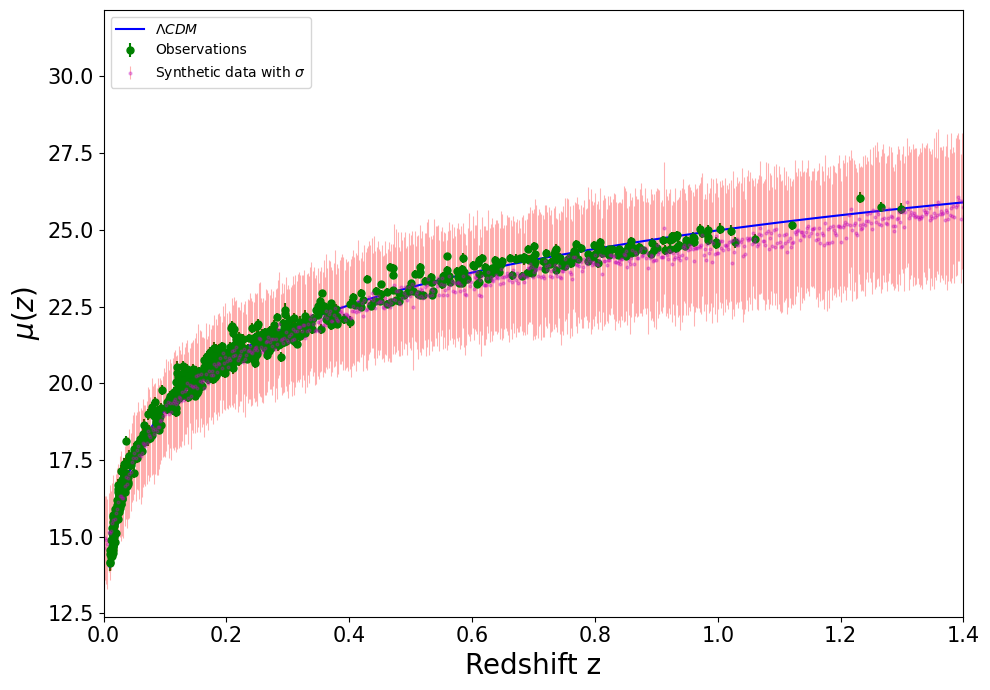

In [20]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zcmb'], df['mb'], df['dmb']**2+df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.4)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()


In [21]:
 prediction_mc_dropout[0,:]

array([14.61509216,  0.13733745,  0.17415394])

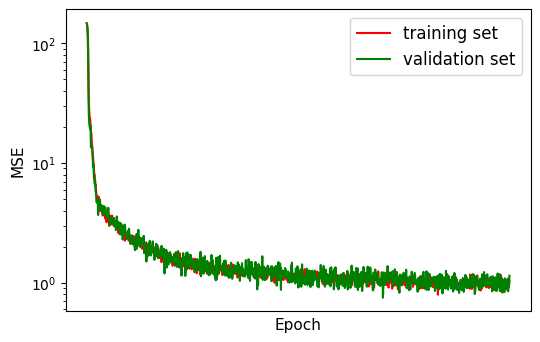

In [22]:
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])
plt.yscale('log')
plt.savefig('loss_v3.png')

In [23]:
mookdp = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("data.dat",mookdp, delimiter=" ")

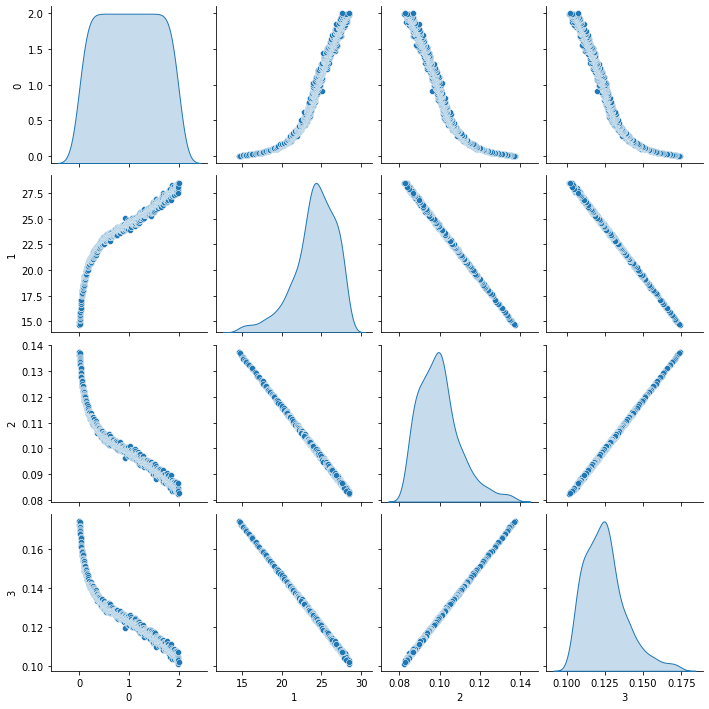

In [24]:
dfMook = pd.DataFrame(mookdp)
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmookdropout.png")

In [25]:
model.save('FFNN_MCDO3is.h5')

PREDICCIÓN SOBRE DATOS DE TESTEO 

In [26]:
from keras.models import load_model

In [27]:
model2 = load_model('FFNN_MCDO3is.h5', custom_objects={'MCDropout': MCDropout})

In [28]:
import pandas as pd
df=pd.read_csv('../../data/not_in _jla.csv')

In [29]:
dmag =df["dmb"]

In [30]:
#df = df[["zcmb", "mb","errors"]]

In [31]:
N = len(df.values)

Text(0, 0.5, '$\\mu(z)$')

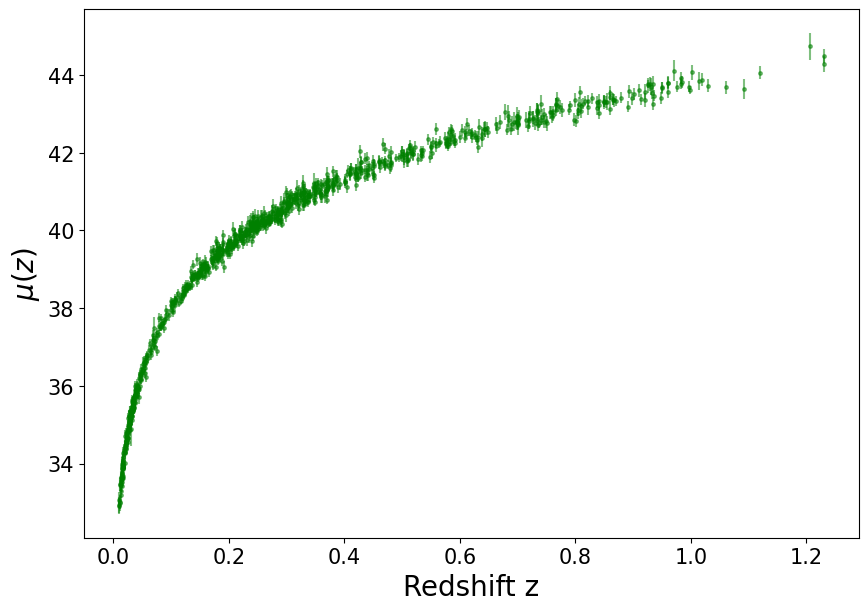

In [32]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
# plt.xlim(0, 2.3)

In [33]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [34]:
z = data[:,0]
y = data[:,1:] ### coge el resto de variables a predecir 
# print(randomize)

In [35]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [36]:
### Modificar para incluir phanteon como test
split = 0.0
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [37]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

In [38]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.0
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((0, 1), (0, 1), (895, 1), (895, 1))

In [39]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 3))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [40]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(2.0219287459537676, 0.00854266128937054)

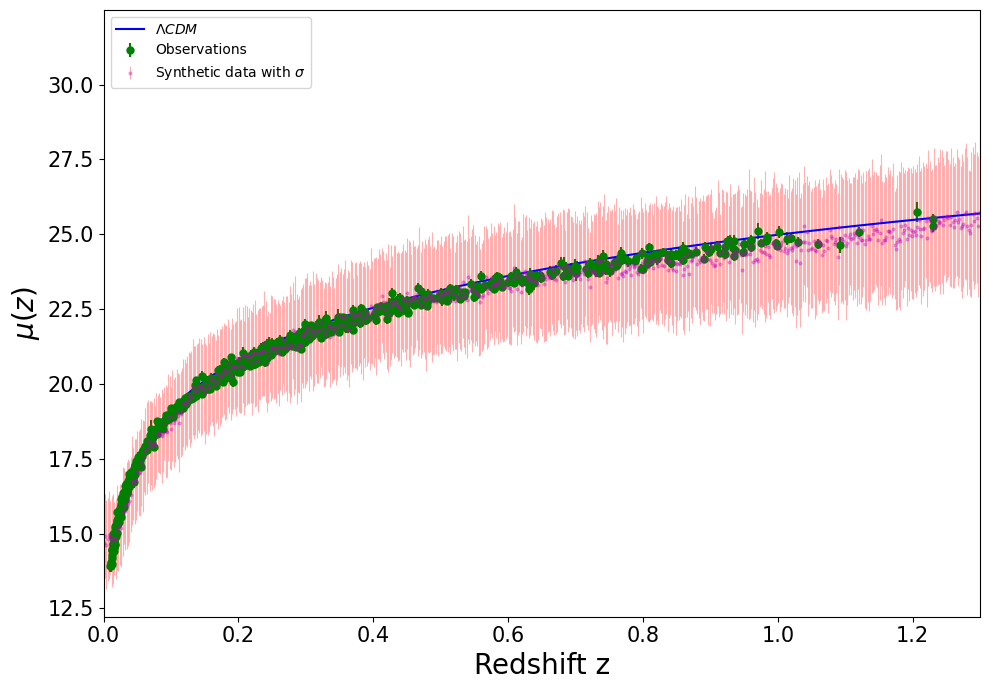

In [41]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)
plt.xlim(0, 1.3)
# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()
plt.savefig("prediction_MCDO.png")